In [1]:
import sys
sys.path.append('lib')
# lib contains util, functions, models, image, normalizers, extract_xml, functools

from openslide import OpenSlide
from os import listdir
from os.path import join, isfile, exists, splitext
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from skimage import measure
import time
from skimage.viewer import ImageViewer
import tensorflow as tf
import keras
import warnings
warnings.filterwarnings("ignore")   
from scipy import interpolate

from util import otsu_thresholding, center_of_slide_level,connected_component_image
from scipy import ndimage
from functions import *
#from models import getModel


/home/mara/venv/local/lib/python2.7/site-packages/skimage/viewer/__init__.py:6: UserWarning: Viewer requires Qt
  warn('Viewer requires Qt')
/home/mara/venv/local/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
from keras.preprocessing import image
from keras.applications import resnet50
import keras.applications.inception_v3
import sys
sys.path.insert(0, '/mnt/nas2/results/Models')
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from resnet101 import *
from googlenet import *
from keras.preprocessing import image
import tensorflow as tf

def getModel(net_settings, num_classes=1, imagenet_weights_path=""):
    '''
        Should be modified with model type as input and returns the desired model
    '''
    if net_settings['model_type'] == 'resnet':
        base_model = resnet50.ResNet50(include_top=True, weights='imagenet')
        finetuning = Dense(1, activation='sigmoid', name='predictions')(base_model.layers[-2].output)
        model = Model(input=base_model.input, output=finetuning)
        model.compile(loss=net_settings['loss'],
        optimizer=optimizers.SGD(lr=net_settings['lr'],  momentum=0.9, decay=1e-6, nesterov=True),
        metrics=['accuracy'])
        return model
    elif net_settings['model_type'] == 'resnet101':
        model = resnet101_model(224, 224, 3, 1,imagenet_weights_path)
        return model
    elif net_settings['model_type']=='inceptionv3':
        base_model = keras.applications.inception_v3.InceptionV3(include_top=True, weights='imagenet')
        finetuning = Dense(1, activation='sigmoid', name='predictions')(base_model.layers[-2].output)
        model = Model(input=base_model.input, output=finetuning)
        model.compile(loss=net_settings['loss'],
                      optimizer=optimizers.SGD(lr=net_settings['lr'],  momentum=0.9, decay=1e-6, nesterov=True),
                      metrics=['accuracy'])
        return model
    elif net_settings['model_type'] == 'googlenet':
        model = check_print()
        return model
    else:
        print '[models] Ugggh. Not ready for this yet.'
        exit(0)
        return None

In [3]:
import setproctitle
EXPERIMENT_TYPE = 'distributed_inference'
# SET PROCESS TITLE
setproctitle.setproctitle('UC1_{}_{}'.format(EXPERIMENT_TYPE, 'mara'))
CONFIG_FILE='doc/config.cfg'

In [4]:
config = ConfigParser.RawConfigParser(allow_no_value = True)
config.read(CONFIG_FILE)

input_file = config.get("input", "file_name")
xml_source = config.get("settings", "xml_source_fld")
data_folder = config.get("settings", "source_fld")
imagenet_weights_path = config.get("input", "imagenet_weights")
model_weights=config.get("input", "model_weights")
interpret_=config.get("input", "interpret")
n_samples_max=config.get("input", "n_samples")

In [5]:
os.environ["CUDA_VISIBLE_DEVICES"]="0"
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
#config.gpu_options.visible_device_list = sys.argv[2] 
keras.backend.tensorflow_backend.set_session(tf.Session(config=config))

folder='./model_weights/'
#0609-1648/'


settings = parseTrainingOptions(CONFIG_FILE)
print settings

model=getModel(settings, imagenet_weights_path=imagenet_weights_path)
model.load_weights(model_weights)

{'loss': 'binary_crossentropy', 'verbose': 1, 'decay': 1e-06, 'nesterov': 'True', 'activation': 'sigmoid', 'batch_size': 32, 'epochs': 15, 'lr': 0.0001, 'model_type': 'resnet101', 'momentum': 0.9}


In [6]:
if interpret_:
    import interpret
    reload(interpret)
    from interpret import *
    print "interpreting network"
    res_folder = 'results/'
    new_folder = res_folder + 'interpretability/'
    if not os.path.exists(new_folder):
        os.makedirs(new_folder)
    new_folder = res_folder + 'interpretability/{}'.format(input_file)
    if not os.path.exists(new_folder):
        os.makedirs(new_folder)
    n_samples=0
    input_size=(224,224)

interpreting network


In [7]:
pwd=""
from os.path import join,isfile, exists, splitext
def get_folder(file_name, path=""):
    for fold in os.listdir(path)[:4]:
        m = file_name+".tif"
        if m in os.listdir(path+fold):
            return fold
    return path
def preprocess_test_data(slide_path, slide_level=7, patch_size=224, verbose=1):
    rgb_im, slide = load_slide(slide_path, slide_level=slide_level)
    otsu_im = get_otsu_im(rgb_im, verbose = 0)
    return slide, rgb_im, otsu_im

def apply_morph(otsu_im):
    im_gray_ostu = otsu_im
    kernel = np.ones((2,2),np.uint8)
    kernel_1 = np.ones((5,5),np.uint8)
    opening = cv2.morphologyEx(im_gray_ostu,cv2.MORPH_OPEN,kernel)
    opening_1 = cv2.morphologyEx(im_gray_ostu,cv2.MORPH_OPEN,kernel_1)
    closing = cv2.morphologyEx(im_gray_ostu,cv2.MORPH_CLOSE,kernel)
    opening_1= np.abs(255-opening_1)
    return opening_1

def preprocess_test_data(slide_path, slide_level=7, patch_size=224, verbose=1):
    rgb_im, slide = load_slide(slide_path, slide_level=slide_level)
    otsu_im = get_otsu_im(rgb_im, verbose = 0)
    return slide, rgb_im, otsu_im

def apply_morph(otsu_im):
    im_gray_ostu = otsu_im
    kernel = np.ones((2,2),np.uint8)
    kernel_1 = np.ones((5,5),np.uint8)
    opening = cv2.morphologyEx(im_gray_ostu,cv2.MORPH_OPEN,kernel)
    opening_1 = cv2.morphologyEx(im_gray_ostu,cv2.MORPH_OPEN,kernel_1)
    closing = cv2.morphologyEx(im_gray_ostu,cv2.MORPH_CLOSE,kernel)
    opening_1= np.abs(255-opening_1)
    return opening_1

training_slide=True
file_name = input_file
print file_name
xml_path=xml_source+file_name+'.xml'
folder = get_folder(file_name,path=data_folder)
print folder
filename =data_folder+folder+"/"+file_name+'.tif' 
slide_path = join(pwd,filename)
print "file name : "+slide_path+"\n"
if isfile(slide_path):
    """is it file? """
    slide=OpenSlide(slide_path)
elif exists(slide_path):
    """ dose it exist? """
    print "slide_path :" + slide_path + " is not a readable file \n"
else:
    """ it is not a file and doesn't exist"""
    print "file dosen't exist in this path :"  + slide_path+"\n"

slide_w, slide_h = slide.dimensions
print "Whole Slide dimensions (with, heigth):{0}\n".format(slide.dimensions)
#Slide.level_dimensions
slide_level = 7
s_level_w, s_level_h = slide.level_dimensions[slide_level]
print "slide.level_count-1 dimensions (width,heigth):{0}\n".format(slide.level_dimensions[slide_level])
slide, rgb_im, otsu_im = preprocess_test_data(slide_path, slide_level=7, patch_size=224, verbose=1)

if not training_slide:
    slide, rgb_im, otsu_im = preprocess_test_data(slide_path, slide_level=7, patch_size=224, verbose=1)

    ## to be continued....
else:
    slide, annotations_mask, rgb_im, im_contour = preprocess(slide_path, xml_path, slide_level=slide_level)


patient_051_node_2
centre_2
file name : /mnt/nas4/datasets/ToReadme/CAMELYON17/centre_2/patient_051_node_2.tif

Whole Slide dimensions (with, heigth):(147456, 111104)

slide.level_count-1 dimensions (width,heigth):(1152, 868)

[235. 230. 225. ... 247. 247. 247.]
Otsu threshold:  170.490234375
[functions][data_preprocessing] NEW PREPROCESS FUNCTION


In [8]:
dmodels={}
import subprocess as sp
def get_gpu_memory():
    _output_to_list = lambda x: x.decode('ascii').split('\n')[:-1]
    ACCEPTABLE_AVAILABLE_MEMORY = 1024
    COMMAND = "nvidia-smi --query-gpu=memory.free --format=csv"
    memory_free_info = _output_to_list(sp.check_output(COMMAND.split()))[1:]
    memory_free_values = [int(x.split()[0]) for i, x in enumerate(memory_free_info)]
    print(memory_free_values)
    return memory_free_values

free_gpu_memory_ = get_gpu_memory()
MEMO_REQUIREMENT = 3000.
n_models = int(free_gpu_memory_[0] / MEMO_REQUIREMENT)
# Distribute inference : GPU Parallelism
print "Distributing inference over {} model copies".format(n_models)
for i in range(0, n_models):
    try: 
        print "Instantiating model n. ", i
        nmodel=getModel(settings, imagenet_weights_path=imagenet_weights_path)
        print "Loading weights..."
        nmodel.load_weights(model_weights)
        print "Adding model to available models."
        dmodels[i]=nmodel
        i+=1
    except:
        print "Something went wrong. Check the memory status. Otherwise failed loading model weights"
        break

[14619]
Distributing inference over 4 model copies
Instantiating model n.  0
Loading weights...
Adding model to available models.
Instantiating model n.  1
Loading weights...
Adding model to available models.
Instantiating model n.  2
Loading weights...
Adding model to available models.
Instantiating model n.  3
Loading weights...
Adding model to available models.


In [9]:
import multiprocessing
opening_1 = apply_morph(otsu_im)
plt.rcParams['figure.figsize']=(5,5)
y_low, x = np.unique(np.where(opening_1>0)[0]), np.unique(np.where(opening_1>0)[1]) 
patch_size=224
patches=[]
flag=False
dim_x, dim_y=slide.level_dimensions[slide_level]
print 'Heatmap dimensions: ', dim_x, dim_y

Heatmap dimensions:  1152 868


In [10]:
heatmap=np.zeros((slide.level_dimensions[slide_level][1], slide.level_dimensions[slide_level][0]))
seen=np.zeros((slide.level_dimensions[slide_level][1], slide.level_dimensions[slide_level][0]))        
resolution=2
mesh = np.meshgrid(np.arange(0, slide.level_dimensions[slide_level][0], 2),np.arange(0, slide.level_dimensions[slide_level][1], 2))
positions = np.vstack(map(np.ravel, mesh)).T
final_p=[]
to_interpret=[]
to_interpret_loc=[]
for p in positions:
    x,y=p[0],p[1]
    if np.sum(opening_1[y-(resolution/2):y+(resolution/2), x-(resolution/2):x+(resolution/2)])>0:
        if y>50 and y<(dim_y-50) and x>50 and x<(dim_x-50):
            final_p.append(p)


In [ ]:
def worker(slide, locations_vector, locations_index, data_batch, data_locations, batch_size=32):
    """worker function for multiprocessing"""
    batch=[]
    batch_locations = locations_vector[locations_index.value:locations_index.value+batch_size]
    for l in batch_locations:
        #l[0] is x, l[1] is y
        patch=np.asarray(slide.read_region((l[0]*128,l[1]*128),0,(224,224)))[...,:3]
        batch.append(np.asarray(patch)[...,:3])
        #Image.fromarray(patch).save('prova_batch/{}-{}.png'.format(l[1],l[0]))
    data_batch[0]=batch
    data_locations[0]=batch_locations
    with locations_index.get_lock():
        locations_index.value +=batch_size
    return

start_time = time.time()
locations_index = multiprocessing.Value("i", 0)
manager = multiprocessing.Manager()
batches = {}
locations = {}
for b in range(n_models):
    batches[b]=manager.dict()
    locations[b]=manager.dict()
#batches=manager.dict()
batch_size=32
while locations_index.value < len(final_p):
    jobs = []
    for m in range(n_models):
        p = multiprocessing.Process(target=worker, 
                                    args=(slide, 
                                          final_p, 
                                          locations_index, 
                                          batches[m], 
                                          locations[m]))
        jobs.append(p)
        p.start() 
        p.join()
        predictions=dmodels[m].predict(np.reshape(batches[m][0],(len(batches[m][0]),224,224,3)))
        for p in range(len(predictions)):
            x_b, y_b=locations[m][0][p][0], locations[m][0][p][1]
            heatmap[y_b, x_b]=predictions[p][0]
            if interpret and predictions[p][0]>0.90 and n_samples<int(n_samples_max):
                print n_samples, n_samples_max, predictions[p][0], n_samples<int(n_samples_max)
                pred_layer = dmodels[m].layers[-1].name
                inputs = np.expand_dims(batches[m][0][p], axis=0)
                conv_layer='res5c_relu'
                cam_=cam(model, inputs, conv_layer, input_size)
                #plt.figure()
                #plt.imshow(cam_)
                plt.rcParams['figure.figsize']=(5,5)
                #plt.savefig('{}/{}_{}'.format(new_folder,x_b,y_b))
                plt.figure()
                plt.imshow(np.uint8(batches[m][0][p]))
                plt.imshow(cam_, alpha=.6, cmap='jet')
                plt.savefig('{}/{}_{}_overlay'.format(new_folder,x_b,y_b))
                n_samples+=1
            seen[y_b,x_b]=1
end_time = time.time()

points = np.asarray(seen.nonzero()).T
values = heatmap[heatmap.nonzero()]

grid_x, grid_y = np.mgrid[0:slide.level_dimensions[slide_level][1]:1, 
                          0:slide.level_dimensions[slide_level][0]:1]
interpolated_heatmap = interpolate.griddata(points, values,
                                      (grid_x, grid_y), 
                                        fill_value=0.
                                       )

Number of patches analysed:  24808.0
Elapsed time:  770.9064641


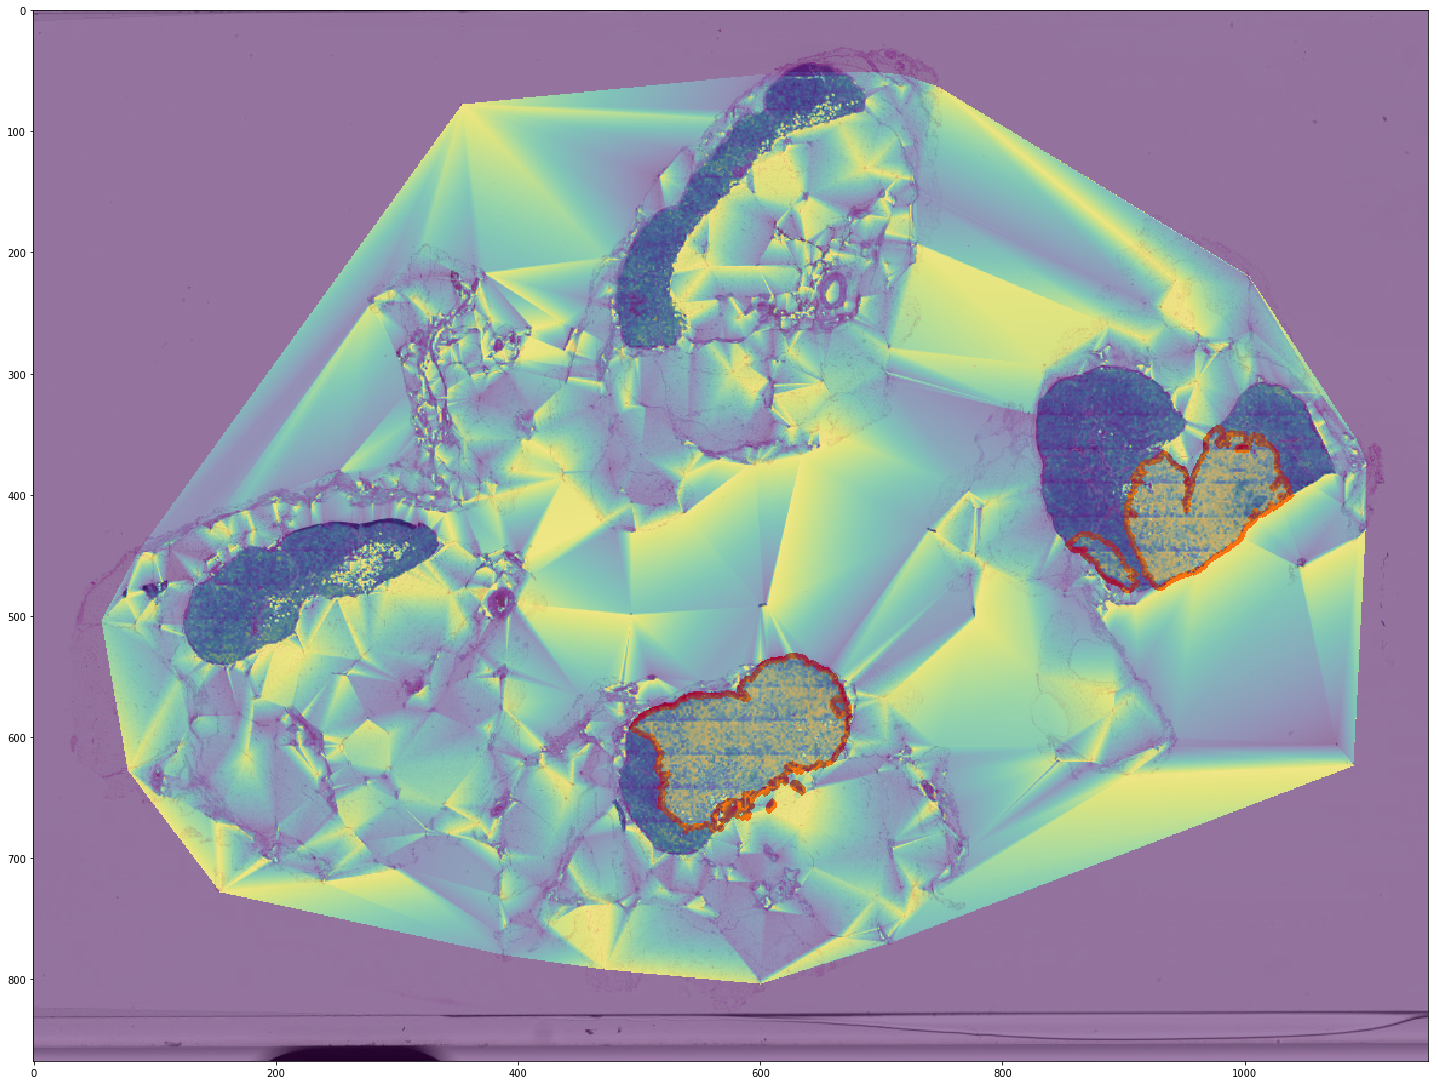

In [12]:
print 'Number of patches analysed: ', np.sum(seen)
print 'Elapsed time: ', end_time-start_time
plt.rcParams['figure.figsize']=(25,25)
plt.imshow(im_contour)
#plt.imshow(heatmap, alpha=0.5)
plt.imshow(interpolated_heatmap, alpha=0.5)
plt.savefig('results/{}_interpolated'.format(file_name))

Number of patches analysed:  24808.0
Elapsed time:  770.9064641


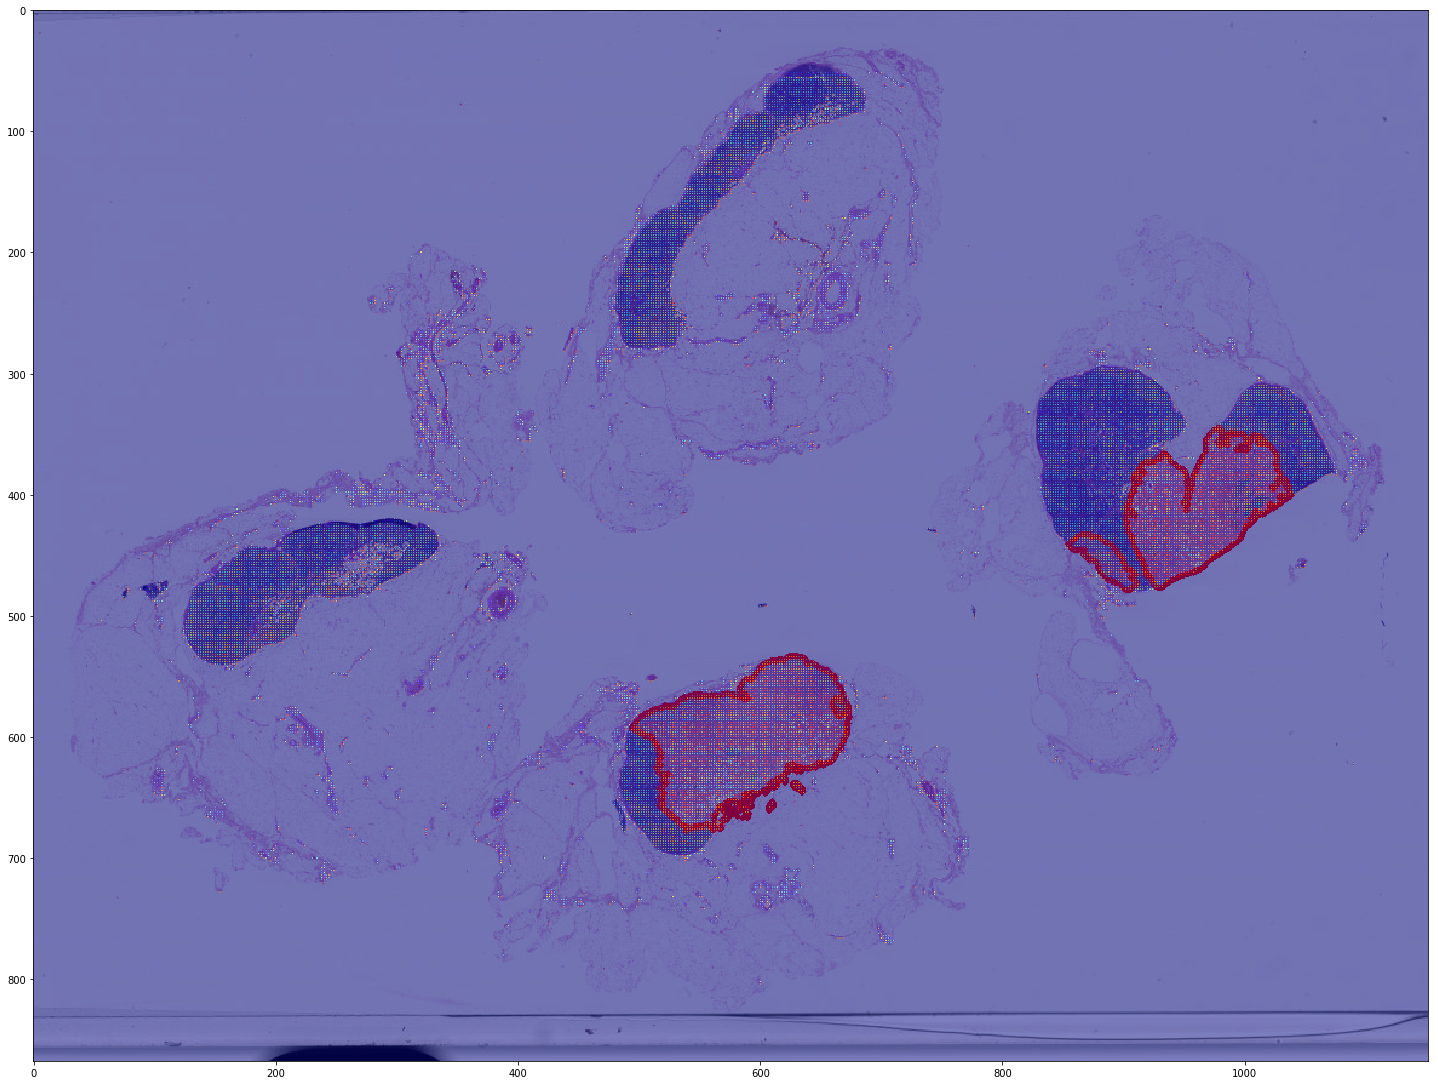

In [13]:
interpolated_heatmap = interpolate.griddata(points, values,
                                      (grid_x, grid_y), 
                                        fill_value=1.
                                       )
print 'Number of patches analysed: ', np.sum(seen)
print 'Elapsed time: ', end_time-start_time
plt.rcParams['figure.figsize']=(25,25)
plt.imshow(im_contour)
#plt.imshow(heatmap, alpha=0.5)
plt.imshow(heatmap, cmap="jet", alpha=0.5)
plt.savefig('results/{}'.format(file_name))
f=open('results/{}_log.txt'.format(file_name),'w')
f.write('Number of patches analysed: {}\n'.format(np.sum(seen)))
f.write('Elapsed time: {} s'.format(end_time-start_time))
f.close()